In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import wandb
import pandas as pd
from prosit_t.wandb_agent.train_utils import get_proteometools_data
from dlomix.losses import masked_spectral_distance
import os
from prosit_t.models import PrositTransformerV2
from dlomix.models import PrositIntensityPredictor
import numpy as np
import tensorflow.keras.backend as K
from prosit_t.inference.visualization import compare_spectra, compare_multiple_spectra, compare_spectra_annotated
from prosit_t.data.parquet_to_tfdataset_padded_filtered import (
    get_tfdatasets_padded_filtered,
)
from prosit_t.eval import prosit_transformer_eval


2023-11-29 17:27:47.409109: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-29 17:27:47.875153: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-29 17:27:49.894434: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-11-29 17:27:49.894531: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [3]:
import plotly.io as pio
pio.renderers.default = "iframe"
import plotly.express as px

In [4]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [5]:
data_config = {
    "dataset": "proteometools",
    "data_source": {
        "train": "/cmnfs/proj/prosit/Transformer/first_pool_train.parquet",
        "val": "/cmnfs/proj/prosit/Transformer/first_pool_test.parquet",
    },
    "fragmentation": "HCD",
    "batch_size": 1024,
    "seq_length": 30,
}

In [6]:
project_name = "transforming-prosit-first-pool"
run = wandb.init(project=project_name)

wandb: Currently logged in as: mamisashvili-lizi (prosit-compms). Use `wandb login --relogin` to force relogin


In [7]:
_, val_data = get_proteometools_data(data_config)

2023-11-29 17:29:37.536383: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-29 17:29:37.699362: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43607 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:21:00.0, compute capability: 8.6


In [11]:
artifact_path = "prosit-compms/transforming-prosit-first-pool/model-hardy-pine-74:v144"
artifact = run.use_artifact(artifact_path)
model_dir = artifact.download()
transformer = PrositTransformerV2(
    seq_length=30,
    embedding_output_dim=64,
    num_heads=16,
    num_transformers=6,
    dense_dim_factor=4
)
transformer.load_weights(model_dir)

wandb:   5 of 5 files downloaded.  
2023-11-30 00:21:17.935293: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ./artifacts/model-hardy-pine-74:v144: FAILED_PRECONDITION: artifacts/model-hardy-pine-74:v144; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


In [12]:
baseline_path = "prosit-compms/transforming-prosit-first-pool/model-classic-star-15:v19"
baseline_artifact = run.use_artifact(baseline_path)
baseline_dir = baseline_artifact.download()

baseline = PrositIntensityPredictor(seq_length=30,embedding_output_dim=16,
        recurrent_layers_sizes=(256, 512))

baseline.load_weights(baseline_dir)

wandb:   4 of 4 files downloaded.  
2023-11-30 00:21:20.314215: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ./artifacts/model-classic-star-15:v19: FAILED_PRECONDITION: artifacts/model-classic-star-15:v19; Is a directory: perhaps your file is in a different file format and you need to use a different restore operator?


In [83]:
batch_idx = 0
batch_x, batch_y = [x for x in val_data.skip(batch_idx).take(1)][0]

transformer_pred = transformer.predict(batch_x)
transformer_loss = masked_spectral_distance(batch_y, transformer_pred)
transformer_loss = tf.round(transformer_loss * 1000) / 1000

baseline_pred = baseline.predict(batch_x)
baseline_loss = masked_spectral_distance(batch_y, baseline_pred)
baseline_loss = tf.round(baseline_loss * 1000) / 1000

32/32 [==============================] - 0s 3ms/step


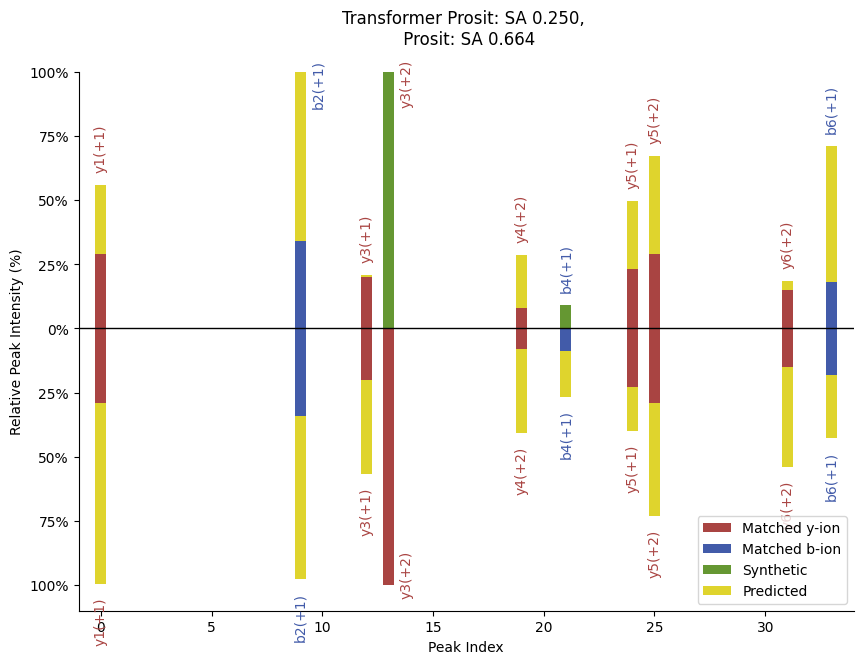

In [81]:
sample_idx = 266
compare_spectra_annotated_mirror(
    batch_y[sample_idx], 
    transformer_pred[sample_idx],
    baseline_pred[sample_idx], 
    transformer_loss[sample_idx],
    baseline_loss[sample_idx], 
    "Transformer Prosit",
    "Prosit",
    "lower right"
)